<a href="https://colab.research.google.com/github/Elman295/TransUnet-for-Surgical-Scene-Segmentation/blob/main/TransUnet_Robot_surgery_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_snippets

In [2]:
# !pip install segmentation_models_pytorch

In [26]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import glob
import random
from torch_snippets import *
# import segmentation_models_pytorch as smp
import torchmetrics

import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader

#`Download Data`

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! kaggle datasets download -d yjh4374/sisvse-dataset

Dataset URL: https://www.kaggle.com/datasets/yjh4374/sisvse-dataset
License(s): other
100% 2.98G/2.98G [00:33<00:00, 61.9MB/s]
100% 2.98G/2.98G [00:33<00:00, 95.4MB/s]


In [7]:
with ZipFile("sisvse-dataset.zip","r") as f:
  f.extractall("data")

In [8]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

In [9]:
images=sorted(glob.glob('data/miccai2022_sisvse_dataset/images/real/*.jpg'))
train_labels1=sorted(glob.glob('data/miccai2022_sisvse_dataset/semantic_masks/real_train_1/*.png'))
train_labels2=sorted(glob.glob('data/miccai2022_sisvse_dataset/semantic_masks/real_train_1/*.png'))
train_labels3=sorted(glob.glob('data/miccai2022_sisvse_dataset/semantic_masks/real_train_1/*.png'))
train_labels=train_labels2
test_labels=sorted(glob.glob('data/miccai2022_sisvse_dataset/semantic_masks/real_val_2/*.png'))

In [10]:
def find_image(name,directory):
    name=name.split('/')[-1].split('.')[0]
    for i in directory:
        if name in i:
            return i

In [11]:
class SegData(Dataset):
    def __init__(self,labels):
        self.images=images
        self.labels=labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, ix):
        path=self.labels[ix]
        image_path=find_image(path,self.images)
        image = cv2.imread(image_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))
        mask = read(path,1)
        mask = cv2.resize(mask, (224,224))
        mask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
        return image, mask
    def choose(self): return self[random.randint(len(self.labels))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.tensor(mask)[None] for mask in masks]).long().to(device)
        return ims, ce_masks

In [12]:
train_dataset=SegData(labels=train_labels)
test_dataset=SegData(labels=test_labels)

(224, 224, 3)
(224, 224)
(224, 224, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


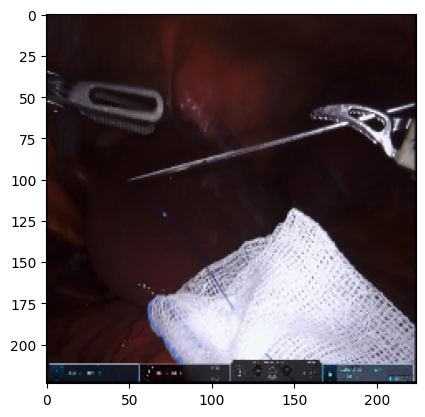

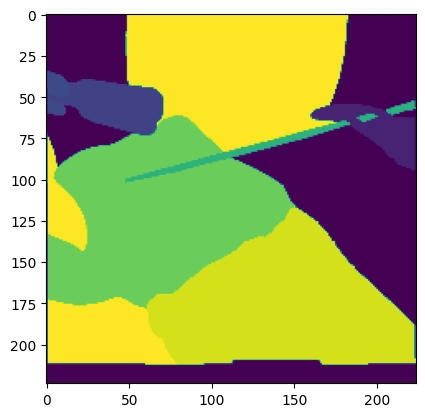

In [13]:
image,mask=train_dataset[10]
print(image.shape)
print(mask.shape)
plt.imshow(image)
plt.figure()
plt.imshow(mask)
print(image.shape)
print(mask)

In [14]:
trn_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn,drop_last=True)
test_dl=DataLoader(test_dataset,batch_size=4,shuffle=True,collate_fn=test_dataset.collate_fn,drop_last=True)

In [15]:
images, masks = next(iter(trn_dl))

In [16]:


print(images.shape)

torch.Size([4, 3, 224, 224])


In [17]:
print(masks.dtype)

torch.int64


#`TransUnet`

In [18]:
class TransUnet(nn.Module):

  def __init__(self, output_classes):
    super(TransUnet, self).__init__()

    ####  Encoder Conv

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(3,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Conv2d(16,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU()
    )

    self.mp_block_1 = nn.MaxPool2d(2,2, return_indices=True)

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU()
    )

    self.mp_block_2 = nn.MaxPool2d(2,2,return_indices=True)

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(32,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.mp_block_3 = nn.MaxPool2d(2,2, return_indices=True)

    self.conv_block_4 = nn.Sequential(
        nn.Conv2d(64,128,3,1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3,1),
        nn.BatchNorm2d(128),
        nn.ReLU()
    )

    self.mp_block_4 = nn.MaxPool2d(2,2,return_indices=True)

    ########################################

    #### Encoder Transformer

    self.encoder_layer = nn.TransformerEncoderLayer(100,10,dim_feedforward=1024)
    self.encoder = nn.TransformerEncoder( self.encoder_layer, num_layers=5)
    ###################################################################

    ### Decoder Deconv

    self.mpu_block_4 = nn.MaxUnpool2d(2,2)
    self.conv_4 = nn.Sequential(
        nn.Conv2d(256,128,3,1,padding=1),
        nn.ReLU()
    )
    self.deconv_4_block = nn.Sequential(
        nn.ConvTranspose2d(128,64,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(64,64,3,1),
        nn.ReLU()
    )

    self.mpu_block_3 = nn.MaxUnpool2d(2,2)

    self.conv_3 = nn.Sequential(
        nn.Conv2d(128,64,3,1,padding = 1),
        nn.ReLU()
    )

    self.deconv_3_block = nn.Sequential(
        nn.ConvTranspose2d(64,32,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(32,32,3,1),
        nn.ReLU()

    )

    self.mpu_block_2 = nn.MaxUnpool2d(2,2)

    self.conv_2 = nn.Sequential(
        nn.Conv2d(64,32,3,1,padding = 1),
        nn.ReLU()
    )

    self.deconv_2_block = nn.Sequential(
        nn.ConvTranspose2d(32,16,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(16,16,3,1),
        nn.ReLU()
    )

    self.mpu_block_1 = nn.MaxUnpool2d(2,2)

    self.conv_1 = nn.Sequential(
        nn.Conv2d(32,16,3,1, padding=1),
        nn.ReLU()
    )

    self.deconv_1_block = nn.Sequential(
        nn.ConvTranspose2d(16,8,3,1),
        nn.ReLU(),
        nn.ConvTranspose2d(8,6,3,1),
        nn.ReLU()
    )

    self.conv_final = nn.Conv2d(6,output_classes,1,1)



  def forward(self, x):

    x1 = self.conv_block_1(x)
    f1,i1 = self.mp_block_1(x1)
    x2 = self.conv_block_2(f1)
    f2,i2 = self.mp_block_2(x2)
    x3 = self.conv_block_3(f2)
    f3,i3 = self.mp_block_3(x3)
    x4 = self.conv_block_4(f3)
    f4, i4 = self.mp_block_4(x4)

    f4 = f4.view((-1,128,10*10))
    f5 = self.encoder(f4)
    f5 = f5.view((-1,128,10,10))

    f6 = self.mpu_block_4(f5, i4)
    f7 = self.conv_4(torch.cat((x4, f6), dim = 1))
    f8 = self.deconv_4_block(f7)

    f9 = self.mpu_block_3(f8, i3, output_size = x3.size())
    f10 = self.conv_3(torch.cat((f9,x3),dim =1 ))
    f11 = self.deconv_3_block(f10)

    f12 = self.mpu_block_2(f11, i2)
    f13 = self.conv_2(torch.cat((f12,x2), dim = 1))

    f14 = self.deconv_2_block(f13)

    f15 = self.mpu_block_1(f14, i1)
    f16 = self.conv_1(torch.cat((f15,x1), dim = 1))
    f17 = self.deconv_1_block(f16)
    f18 = self.conv_final(f17)

    return f18


In [19]:
model = TransUnet(32).to(device)
x = torch.rand(size = (16,3,224,224)).to(device)
y = model(x)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([16, 32, 224, 224])


In [20]:
loss_fn = nn.CrossEntropyLoss()

In [21]:
opt = torch.optim.Adam(params =model.parameters(), lr = 1e-3)

In [22]:
def train(data, model, loss_fn, opt):
  model.train()
  size = len(data.dataset)

  for b, (image, segment) in enumerate(data):

    image, segment = image.to(device), segment.to(device)
    mask_pred = model(image)
    opt.zero_grad()
    loss = loss_fn(mask_pred, segment)
    loss.backward()
    opt.step()

    if b% 100 == 0:
      print(f"loss:{loss.item()} [{b*len(image)} | {size}]")


In [24]:
for e in range(10):
  print(f"epoch:{e+1}=-=-=-=-")
  train(trn_dl, model, loss_fn, opt)

epoch:1=-=-=-=-
loss:1.7485798597335815 [0 | 3375]
loss:1.985133409500122 [400 | 3375]
loss:2.2121737003326416 [800 | 3375]
loss:1.5706369876861572 [1200 | 3375]
loss:1.265755295753479 [1600 | 3375]
loss:1.5091792345046997 [2000 | 3375]
loss:1.161940336227417 [2400 | 3375]
loss:1.638580322265625 [2800 | 3375]
loss:1.5685372352600098 [3200 | 3375]
epoch:2=-=-=-=-
loss:1.3000861406326294 [0 | 3375]
loss:1.8547357320785522 [400 | 3375]
loss:1.760517954826355 [800 | 3375]
loss:1.737173080444336 [1200 | 3375]
loss:1.3214572668075562 [1600 | 3375]
loss:1.6645878553390503 [2000 | 3375]
loss:1.7750393152236938 [2400 | 3375]
loss:1.411173939704895 [2800 | 3375]
loss:1.4411336183547974 [3200 | 3375]
epoch:3=-=-=-=-
loss:1.6064071655273438 [0 | 3375]
loss:1.495535135269165 [400 | 3375]
loss:1.25030517578125 [800 | 3375]
loss:1.3976393938064575 [1200 | 3375]
loss:1.502071499824524 [1600 | 3375]
loss:1.2837132215499878 [2000 | 3375]
loss:1.2194652557373047 [2400 | 3375]
loss:1.3307230472564697 [280

In [28]:
jaccard = torchmetrics.JaccardIndex(task = "multiclass", num_classes=32).to(device)

accuracy: 0.10805105417966843


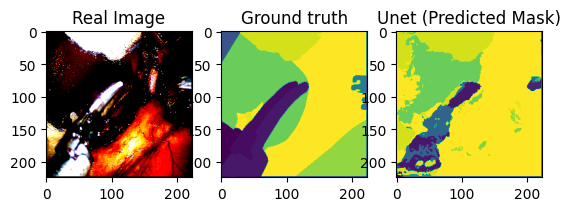

In [30]:
image, seg = next(iter(trn_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)

print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[0].cpu().numpy())
plt.subplot(1,3,3)
plt.title("Unet (Predicted Mask)")
plt.imshow(mask_pred[0].cpu().detach().numpy().argmax(0))

plt.show()

accuracy: 0.19918006658554077


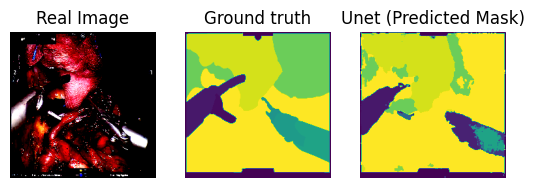

In [37]:
image, seg = next(iter(test_dl))
image = image.to(device)
seg = seg.to(device)
mask_pred = model(image)

print(f"accuracy: {jaccard(mask_pred,seg)}")

plt.subplot(1,3,1)
plt.title("Real Image")
plt.imshow(image[0].cpu().permute(1,2,0))
plt.axis("off")
plt.subplot(1,3,2)
plt.title("Ground truth")
plt.imshow(seg[0].cpu().numpy())
plt.axis("off")
plt.subplot(1,3,3)
plt.title("Unet (Predicted Mask)")
plt.imshow(mask_pred[0].cpu().detach().numpy().argmax(0))
plt.axis("off")

plt.show()